In [ ]:
"""
This is how openPIV python perform FFT cross-correlation in the version v0.22.3 in process.pyx

def correlate_windows( window_a, window_b, corr_method = 'fft', int nfftx = 0, int nffty = 0 ):

    if corr_method == 'fft':
        if nfftx == 0:
            nfftx = 2*window_a.shape[0]
        if nffty == 0:
            nffty = 2*window_a.shape[1]
        return fftshift(irfft2(rfft2(normalize_intensity(window_a),\
            s=(nfftx,nffty))*np.conj(rfft2(normalize_intensity(window_b),\
            s=(nfftx,nffty)))).real, axes=(0,1)  )
    elif corr_method == 'direct':
        return convolve(normalize_intensity(window_a), normalize_intensity(window_b[::-1,::-1]), 'full')
    else:
        raise ValueError('method is not implemented')
        
        
I base the evaluation of FFT in Python on this code, since future version of the Package apply heuristics where
the size of the input is rounded to the next power of two. The effect of this heuristics can be seen in the 
last cells of this notebooks. In short, these heuristics avoid the penalty of performing FFT on arrays of prime 
sizes, but it increases in the size of the input unecessarily for other input array sizes. 

"""

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

def normalize_intensity( window ):
    return window - window.mean()

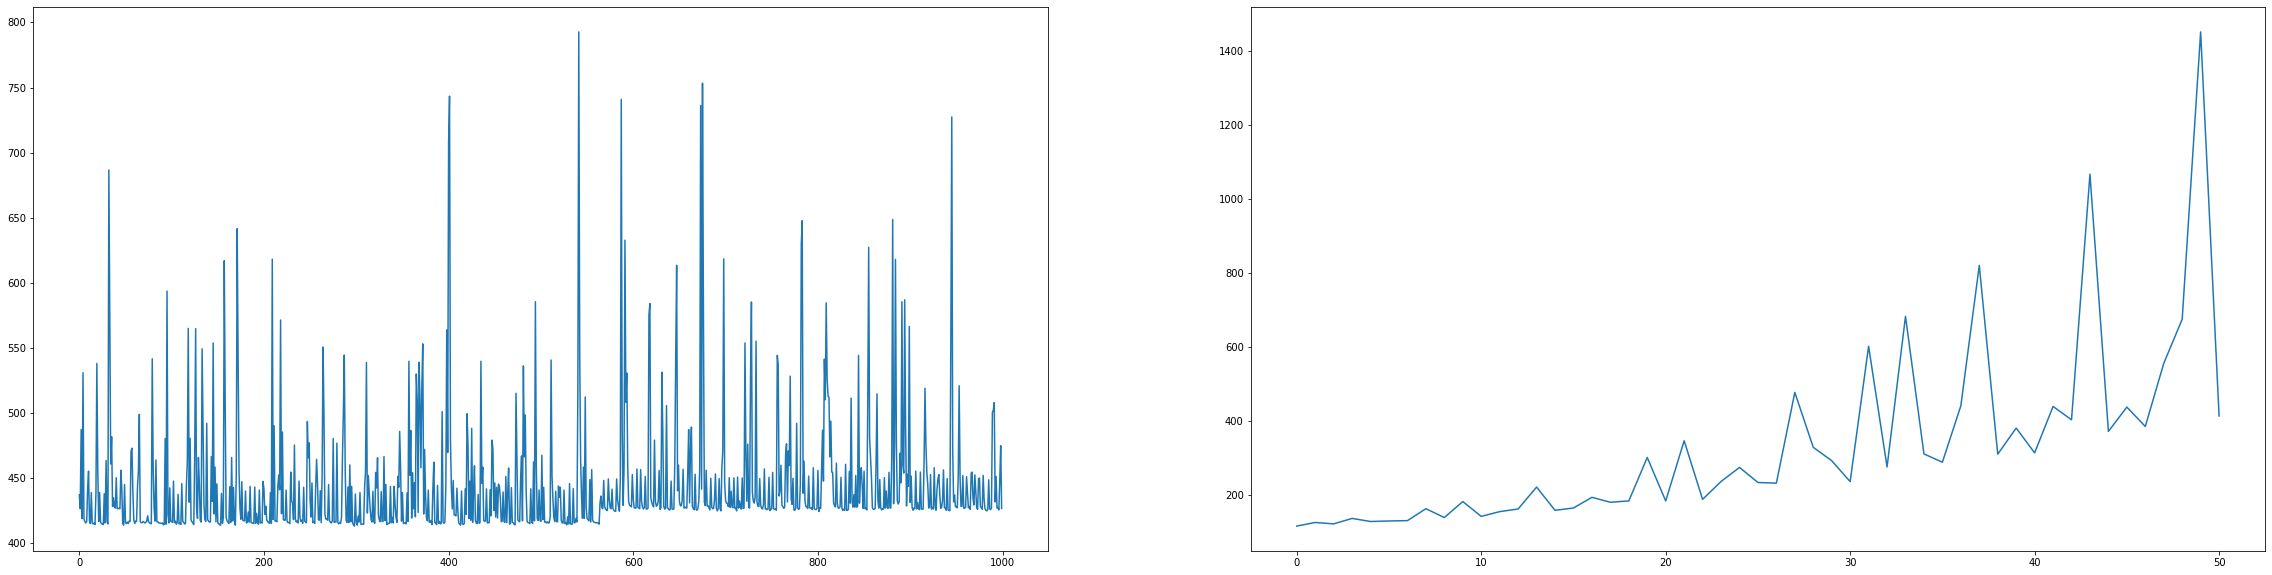

In [9]:
IA0, IAmax, n = 10, 60, 1000;
min_times = np.empty( IAmax - IA0 + 1, dtype=float ); 

for IA in range(IA0,IAmax+1):
    
    i1 = np.zeros( (IA, IA) ); 
    i2 = np.zeros( (IA, IA) );
    tmp_times = np.empty( n, dtype=float );
    
    for e in range(n):
        
        t1 = time.time(); 
        
        nfftx = 2*i1.shape[0]
        nffty = 2*i1.shape[1]
        np.fft.fftshift( \
            np.fft.irfft2(np.fft.rfft2(normalize_intensity(i1),\
            s=(nfftx,nffty))*np.conj(np.fft.rfft2(normalize_intensity(i2),\
            s=(nfftx,nffty)))).real, axes=(0,1) )
        
        ex = time.time() - t1; 
        
        tmp_times[e] = ex * 1000000; 
        
    min_times[IA-IA0] = min(tmp_times)

plt.figure( figsize=( 40, 10 ) ); 
plt.subplot(121); plt.plot( tmp_times );
plt.subplot(122); plt.plot( min_times );

In [10]:
with open('pyTimes.txt', 'w') as f:
    for t in min_times:
        f.write("%d\n" % t )

# Complete PIV analysis with openPIV v 0.23.4 

In [1]:
import sys
sys.path.insert(1,'/home/marc/Desktop/openPIV_speedTests/openpiv-python-0.23.4/')

from openpiv import pyprocess, tools, pyprocess3D
import numpy as np
import time # time.time() Return the time in seconds since the epoch
import matplotlib.pyplot as plt

## 2D Analysis

In [17]:
frame_a = np.random.rand( 512, 512 );
frame_b = np.random.rand( 512, 512 ); 

In [18]:
reps  = 1000
times = np.zeros( reps )

for e in range(reps):

    start = time.time(); 

    pyprocess.extended_search_area_piv( frame_a, frame_b, 
                                        window_size=32, overlap=16, 
                                        dt=1, search_area_size=32, 
                                        sig2noise_method='peak2peak' )

    end = time.time(); 
    
    times[e] = end - start

print( np.min( times ) )

0.160811185836792


## 3D Analysis ( it takes around 1 hour in my machine )

In [3]:
frame_a = np.random.rand( 512, 512, 123 );
frame_b = np.random.rand( 512, 512, 123 ); 

reps  = 100
times = np.zeros( reps )

for e in range(reps):

    start = time.time(); 

    pyprocess3D.extended_search_area_piv3D( frame_a, frame_b, 
                                            window_size=(49,49,11), overlap=(14,14,3), 
                                            dt=(1,1,1), search_area_size=(49,49,11), 
                                            sig2noise_method='peak2peak' )
  
    end = time.time(); 
    
    times[e] = end - start

print( np.min( times ) )

100%|██████████| 14/14 [01:07<00:00,  4.83s/it]

59.724783420562744


### FFT computation with heuristics from openPIV python v 0.23.4

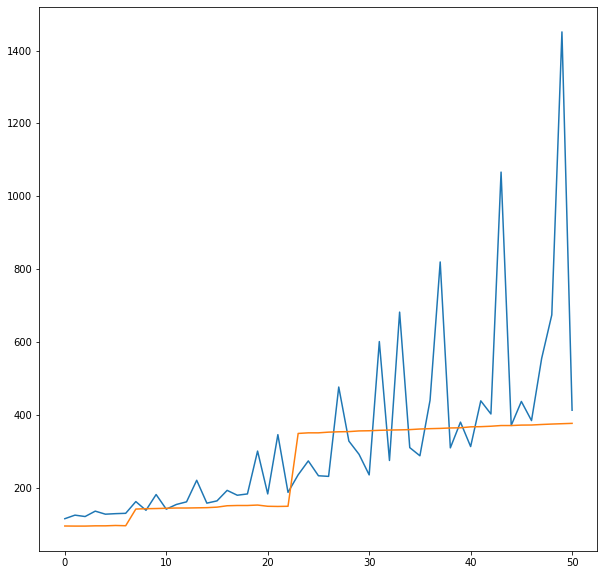

In [15]:
IA0, IAmax, n = 10, 60, 1000;
min_times2 = np.empty( IAmax - IA0 + 1, dtype=float ); 

for IA in range(IA0,IAmax+1):
    
    i1 = np.zeros( (IA, IA) ); 
    i2 = np.zeros( (IA, IA) );
    tmp_times = np.empty( n, dtype=float );
    
    for e in range(n):
        
        t1 = time.time(); 
        
        s1 = np.array(i1.shape)
        s2 = np.array(i2.shape)
        size = s1 + s2 - 1
        fsize = 2 ** np.ceil(np.log2(size)).astype(int)
        fslice = tuple([slice(0, int(sz)) for sz in size])
        f2a = np.fft.rfft2(i1, fsize)
        f2b = np.fft.rfft2(i2[::-1, ::-1], fsize)
        corr = np.fft.irfft2(f2a * f2b).real[fslice]
        
        ex = time.time() - t1; 
        
        tmp_times[e] = ex * 1000000; 
        
    min_times2[IA-IA0] = min(tmp_times)

plt.figure( figsize=( 10, 10 ) ); 
plt.plot( min_times );
plt.plot( min_times2 );